In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import torch, traceback
from torchmin import minimize
from torch import nn
from torch.autograd import Variable

In [457]:
def sample_uniform_2d(n_samples, x_limits, y_limits):
    """
    Uniformly sample points in a 2D box.

    Parameters:
    - n_samples: int, number of points to sample
    - x_limits: tuple (x_min, x_max)
    - y_limits: tuple (y_min, y_max)

    Returns:
    - samples: np.ndarray of shape (n_samples, 2)
    """
    x = np.random.uniform(low=x_limits[0], high=x_limits[1], size=n_samples)
    y = np.random.uniform(low=y_limits[0], high=y_limits[1], size=n_samples)
    return np.stack((x, y), axis=1)


def noised_model(x, ground_truth_mean, ground_truth_cov, N_events, n_noise_bumps=1, noise_width=0.01, epsilon=0.01):
    ground_truth_generator = multivariate_normal(ground_truth_mean, ground_truth_cov)
    x_eval =ground_truth_generator.pdf(x)*N_events
    normalization = N_events
    noise_range = [[ground_truth_mean[0]-5*ground_truth_cov[0][0], ground_truth_mean[0]+5*ground_truth_cov[0][0]],
                   [ground_truth_mean[1]-5*ground_truth_cov[1][1], ground_truth_mean[1]+5*ground_truth_cov[1][1]],
                  ]
    bumps_loc = sample_uniform_2d(n_noise_bumps, x_limits=noise_range[0], y_limits=noise_range[1])
    #print(bumps_loc)
    bumps_loc_ground_truth = ground_truth_generator.pdf(bumps_loc)*N_events
    bumps_sign = np.random.choice([-1, 1], size=n_noise_bumps)
    bumps_amplitude = bumps_sign*np.sqrt(bumps_loc_ground_truth)*epsilon
    for n in range(n_noise_bumps):
        n_generator = multivariate_normal(bumps_loc[n], [[noise_width**2, 0], [0, noise_width**2]])
        x_generator = n_generator.pdf(x)*bumps_amplitude[n]#/n_generator.pdf(bumps_loc[n])
        x_eval += x_generator
        normalization += bumps_amplitude[n]#/n_generator.pdf(bumps_loc[n])
    return x_eval/normalization

def plot_marginal(weights, model_probs, x_limits, ground_truth_generator, ground_truth_mean, ground_truth_cov, 
                  N_models, N_events, N_bumps, bumps_width, bumps_amplitude, axis=0, nn=None, nn_coeff=None):
    x = np.linspace(x_limits[0], x_limits[1], 10000)
    y = np.zeros_like(x)
    if axis==0:
        z = np.stack([x, y], axis=1)
    elif axis==1:
        z = np.stack([y, x], axis=1)
    
    # ground truth
    x_gt = ground_truth_generator.pdf(z)#*N_events
    
    # fitting output
    model_probs = []
    for n in range(N_models):
        np.random.seed(n)
        probs_n = noised_model(z, ground_truth_mean=ground_truth_mean, 
                             ground_truth_cov=ground_truth_cov, 
                             N_events=N_events, n_noise_bumps=N_bumps, noise_width=bumps_width, epsilon=bumps_amplitude)
        model_probs.append(probs_n)
    model_probs = torch.from_numpy(np.stack(model_probs, axis=1))
    print(model_probs.shape)
    
    plt.plot(x, x_gt, label='Ground truth')
    plt.plot(x, probs(weights, model_probs), label='Ensemble')
    if nn!=None:
        net_out=nn.forward(torch.from_numpy(z).float()).detach().numpy().squeeze()
        #p = 0.5*(1+nn_coeff[0])*probs(weights, model_probs) + 0.5*nn_coeff[1]*net_out 
        p = nn_coeff[0]*probs(weights, model_probs) + nn_coeff[1]*net_out 
        plt.plot(x, p, label='ensemble + extra DOF')
        plt.plot(x, coeffs[1]*net_out, label='extra DOF alone')
        plt.plot(x,nn_coeff[0]*probs(weights, model_probs), label='ensemble alone')
    plt.xlabel('Axis %i'%(axis))
    plt.legend()
    plt.show()
    return

# define the ground truth

In [3]:
ground_truth_mean = [0.5, -0.2]
ground_truth_cov = [[2.0, 0.3], [0.3, 0.5]]
ground_truth_generator = multivariate_normal(ground_truth_mean, ground_truth_cov)

# build a toy model for the ensemble

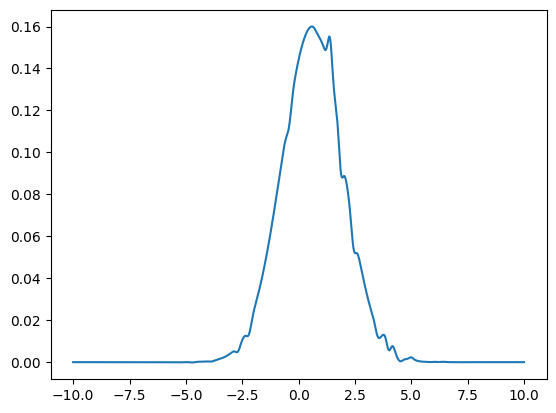

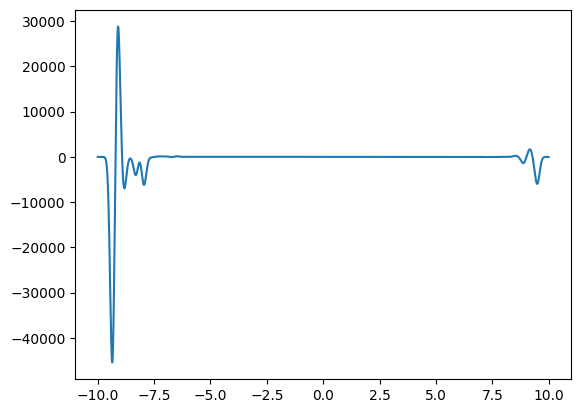

In [4]:

x_limits=[-10, 10]
N_events=1000
x = np.linspace(x_limits[0], x_limits[1], 100000)
y = np.zeros_like(x)
x = np.stack([x, y], axis=1)
x_gt = ground_truth_generator.pdf(x)
x_n = noised_model(x, ground_truth_mean=ground_truth_mean, ground_truth_cov=ground_truth_cov, N_events=N_events, 
                   n_noise_bumps=500, noise_width=0.1, epsilon=0.1)
# model
plt.plot(x[:, 0], x_n)
plt.show()
# ratio with groun truth
plt.plot(x[:, 0], x_n/x_gt)
plt.show()

# fit the ensemble

In [7]:
def constraint_term(weights):
    l =1e5
    return l * (torch.sum(weights) - 1.0)**2 

def probs(weights, model_probs):
    # weights: (M,), model_probs: (N, M)
    return (model_probs * weights).sum(dim=1)  # returns (N,)

def nll(weights):
    p = probs(weights, model_probs)
    if not torch.all(p > 0):
        # Use same device and dtype
        return weights.sum() * float("inf")
    loss = -torch.log(p + 1e-8).mean() + constraint_term(weights)
    return loss

In [8]:
N_models = 5
N_events = 1000
N_bumps = 500
bumps_width = 0.1
bumps_amplitude = 0.1 # fraction of sqrt(n(x))
data = ground_truth_generator.rvs(size=N_events)

In [9]:
model_probs = []
for n in range(N_models):
    np.random.seed(n)
    print(n)
    probs_n = noised_model(data, ground_truth_mean=ground_truth_mean, 
                         ground_truth_cov=ground_truth_cov, 
                         N_events=N_events, n_noise_bumps=N_bumps, noise_width=bumps_width, epsilon=bumps_amplitude)
    model_probs.append(probs_n)
model_probs = torch.from_numpy(np.stack(model_probs, axis=1))
print(model_probs.shape)

0
1
2
3
4
torch.Size([1000, 5])


In [10]:
w_i_initial = np.ones(model_probs.shape[1]) / model_probs.shape[1]
max_attempts = 50  # to avoid infinite loops in pathological cases

attempt = 0
while attempt < max_attempts:
    w_i_init_torch = torch.tensor(w_i_initial, dtype=torch.float64, requires_grad=True)
    noise = 1e-2 * torch.randn_like(w_i_init_torch)
    w_i_init_torch = (w_i_init_torch + noise).detach().clone().requires_grad_()
    print('w_i_init_torch:', w_i_init_torch)

    try:
        loss_val = nll(w_i_init_torch)
        print("loss grad_fn:", loss_val.grad_fn)

        if not torch.isfinite(loss_val):
            print(f"Attempt {attempt+1} skipped due to non-finite loss: {loss_val.item()}")
            continue

        print(f"Attempt {attempt+1}: Starting optimization (loss = {loss_val.item():.4f})")
 
        res = minimize(
            nll,
            w_i_init_torch,
            method='newton-exact',
            options={'disp': False, 'max_iter': 300},
        )

        if res.success:
            print(f"Optimization succeeded on attempt {attempt}")
            break
        attempt += 1
        
    except Exception as e:
        print(f"Attempt {attempt+1} failed with exception: {e}")
        traceback.print_exc()
        attempt += 1


w_i_final = res.x.detach()          
final_loss = nll(w_i_final).item()
print("Final loss (NLL):", final_loss)

w_i_init_torch: tensor([0.1825, 0.1964, 0.2195, 0.2187, 0.2022], dtype=torch.float64,
       requires_grad=True)
loss grad_fn: <AddBackward0 object at 0x104e84760>
Attempt 1: Starting optimization (loss = 39.9230)
Optimization succeeded on attempt 0
Final loss (NLL): 2.740809138554545


In [12]:
w_i_final

tensor([-0.0433,  0.6116, -0.0129,  0.4619, -0.0173], dtype=torch.float64)

In [11]:
# check sum of weights after fitting
torch.sum(w_i_final)

tensor(1.0000, dtype=torch.float64)

## plotting coord 1

0
1
2
3
4
torch.Size([10000, 5])


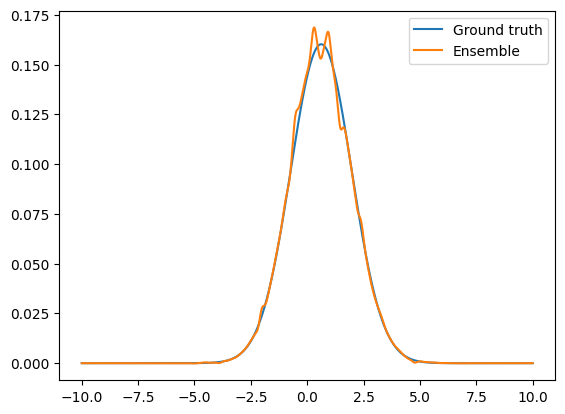

In [10]:
x_limits=[-10, 10]
x = np.linspace(x_limits[0], x_limits[1], 10000)
y = np.zeros_like(x)
z = np.stack([x, y], axis=1)

# ground truth
x_gt = ground_truth_generator.pdf(z)#*N_events

# fitting output
model_probs = []
for n in range(N_models):
    print(n)
    np.random.seed(n)
    probs_n = noised_model(z, ground_truth_mean=ground_truth_mean, 
                         ground_truth_cov=ground_truth_cov, 
                         N_events=N_events, n_noise_bumps=N_bumps, noise_width=bumps_width, epsilon=bumps_amplitude)
    model_probs.append(probs_n)
model_probs = torch.from_numpy(np.stack(model_probs, axis=1))
print(model_probs.shape)

plt.plot(x, x_gt)
plt.plot(x, probs(w_i_final, model_probs))
plt.legend(['Ground truth', 'Ensemble'])

## plotting coord 2

0
1
2
3
4
torch.Size([10000, 5])
4.999999999999995


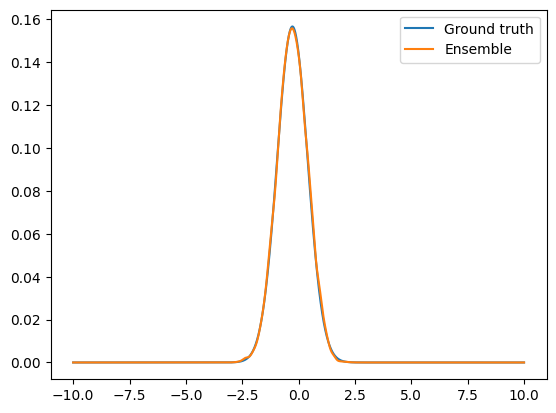

In [58]:
x_limits=[-10, 10]
x = np.linspace(x_limits[0], x_limits[1], 10000)
y = np.zeros_like(x)
z = np.stack([y, x], axis=1)

# ground truth
x_gt = ground_truth_generator.pdf(z)#*N_events

# fitting output
model_probs = []
for n in range(N_models):
    print(n)
    np.random.seed(n)
    probs_n = noised_model(z, ground_truth_mean=ground_truth_mean, 
                         ground_truth_cov=ground_truth_cov, 
                         N_events=N_events, n_noise_bumps=N_bumps, noise_width=bumps_width, epsilon=bumps_amplitude)
    model_probs.append(probs_n)
model_probs = torch.from_numpy(np.stack(model_probs, axis=1))
print(model_probs.shape)

plt.plot(x, x_gt)
plt.plot(x, probs(w_i_final, model_probs))
plt.legend(['Ground truth', 'Ensemble'])
print(np.sum(h[0]))

## generating and plotting histograms

0
1
2
3
4
torch.Size([100000, 5])
4.999999999999996


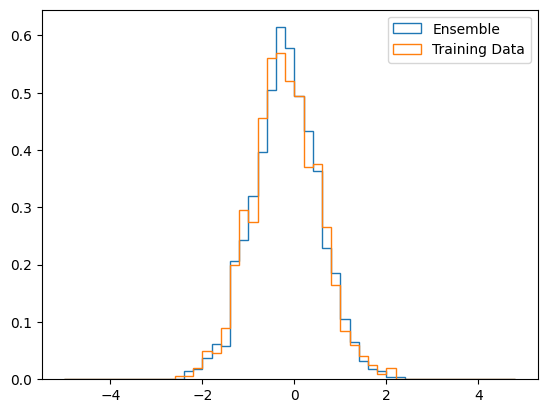

In [60]:
# sample from the model (hit&miss)
z = sample_uniform_2d(100000, x_limits=[-6, 6], y_limits=[-3, 3])
u = np.linspace(0, 1, 100000)
u = torch.from_numpy(u)

model_probs = []
for n in range(N_models):
    print(n)
    np.random.seed(n)
    probs_n = noised_model(z, ground_truth_mean=ground_truth_mean, 
                         ground_truth_cov=ground_truth_cov, 
                         N_events=N_events, n_noise_bumps=N_bumps, noise_width=bumps_width, epsilon=bumps_amplitude)
    model_probs.append(probs_n)
model_probs = torch.from_numpy(np.stack(model_probs, axis=1))
print(model_probs.shape)
f = probs(w_i_final, model_probs)
z = z[u<f]
# plotting
h=plt.hist(z[:, 1], bins=np.arange(-5, 5, 0.2), density=True, histtype='step')
h=plt.hist(data[:, 1], bins=h[1], density=True, histtype='step')
plt.legend(['Ensemble', 'Training Data'])
print(np.sum(h[0]))

4.999999999999995


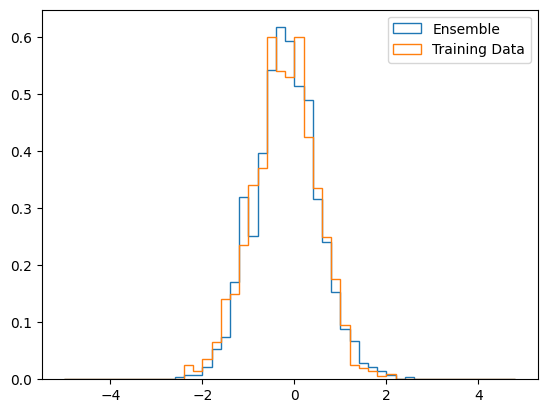

# Likelihood ratio test with uncertainties
the reference model now is our ensemble (with associated uncertainties)

the data are samples drawn from the ground truth 

In [115]:
def aux(weights, weights_0, weights_cov):
    '''
    auxiliary likelihood term.
    it's the likelihood of the nuisance parameters. 
    It's assumed Multivariate Gaussian with Covariance matrix given by the error covariance matrix 
    obtained fitting the {w} to the ensemble  
    '''
    d = torch.distributions.MultivariateNormal(weights_0, covariance_matrix=weights_cov)
    return d.log_prob(weights) 
    
def nll_aux(weights, weights_0, weights_cov):
    '''
    negative log-likelihood (nll) with auxiliary (aux) term included
    '''
    p = probs(weights, model_probs)
    if not torch.all(p > 0):
        # Use same device and dtype
        return weights.sum() * float("inf")
    loss = -torch.log(p + 1e-8).sum() -aux(weights, weights_0, weights_cov).sum()
    return loss

In [180]:
# central value reference hypotehsis (ensemble after ML fit)
w = torch.tensor([-0.0433,  0.6116, -0.0129,  0.4619, -0.0173])
w_unc = torch.from_numpy(np.copy(w_i_final)*0.01)
w_cov = torch.eye(len(w))

# ensemble specifics
N_models = 5
N_events = 1000
N_bumps = 500
bumps_width = 0.1
bumps_amplitude = 0.1 # fraction of sqrt(n(x))

# generate a new dataset (to test)
np.random.seed(1)
data = ground_truth_generator.rvs(size=N_events)
print(np.mean(data))

0.12384260027630208


In [181]:
data

array([[-1.71113857, -1.04011988],
       [ 1.37892143, -0.75737069],
       [-0.42958927, -1.93766988],
       ...,
       [ 1.10660029,  0.04453261],
       [-0.17421076, -0.9540068 ],
       [-0.58630218,  0.52998293]])

In [182]:
# evaluate model on data
model_probs = []
for n in range(N_models):
    np.random.seed(n)
    print(n)
    probs_n = noised_model(data, ground_truth_mean=ground_truth_mean, 
                         ground_truth_cov=ground_truth_cov, 
                         N_events=N_events, n_noise_bumps=N_bumps, noise_width=bumps_width, epsilon=bumps_amplitude)
    model_probs.append(probs_n)
model_probs = torch.from_numpy(np.stack(model_probs, axis=1))
print(model_probs.shape)

0
1
2
3
4
torch.Size([1000, 5])


## fit ensemble with uncertainties

this is Giada's code with a different loss (to account for auxiliary terms)

In [40]:
w_i_initial = np.ones(model_probs.shape[1]) / model_probs.shape[1]
max_attempts = 50  # to avoid infinite loops in pathological cases

attempt = 0
while attempt < max_attempts:
    w_i_init_torch = torch.tensor(w_i_initial, dtype=torch.float64, requires_grad=True)
    noise = 1e-2 * torch.randn_like(w_i_init_torch)
    w_i_init_torch = (w_i_init_torch + noise).detach().clone().requires_grad_()
    print('w_i_init_torch:', w_i_init_torch)

    try:
        loss_val = nll_aux(w_i_init_torch, weights_0=w, weights_cov=w_cov)
        print("loss grad_fn:", loss_val.grad_fn)

        if not torch.isfinite(loss_val):
            print(f"Attempt {attempt+1} skipped due to non-finite loss: {loss_val.item()}")
            continue

        print(f"Attempt {attempt+1}: Starting optimization (loss = {loss_val.item():.4f})")
 
        res = minimize(
            nll,
            w_i_init_torch,
            method='newton-exact',
            options={'disp': False, 'max_iter': 300},
        )

        if res.success:
            print(f"Optimization succeeded on attempt {attempt}")
            break
        attempt += 1
        
    except Exception as e:
        print(f"Attempt {attempt+1} failed with exception: {e}")
        traceback.print_exc()
        attempt += 1


w_i_final = res.x.detach()          
final_loss = nll(w_i_final).item()
print("Final loss (NLL):", final_loss)

w_i_init_torch: tensor([0.2058, 0.2186, 0.2103, 0.1961, 0.1911], dtype=torch.float64,
       requires_grad=True)
loss grad_fn: <SubBackward0 object at 0x29ad87f70>
Attempt 1: Starting optimization (loss = 2790.4623)
Optimization succeeded on attempt 0
Final loss (NLL): 2.802609773965738


In [41]:
# final values of w (fit with aux constraint on the test sample)
w_i_final

tensor([ 0.6815,  0.5068, -0.1528, -0.1743,  0.1389], dtype=torch.float64)

In [17]:
# original values of w (fit without aux constraint on the training sample)
w

tensor([-0.0433,  0.6116, -0.0129,  0.4619, -0.0173])

torch.Size([10000, 5])


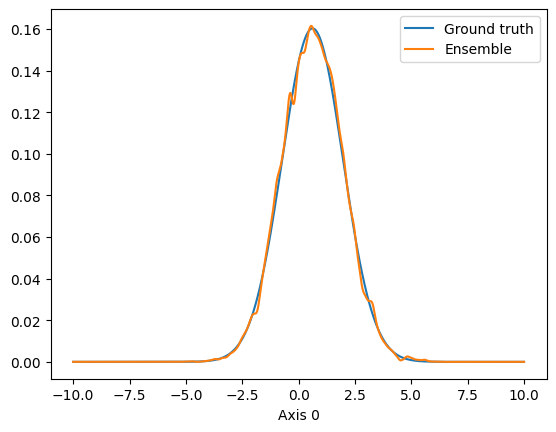

torch.Size([10000, 5])


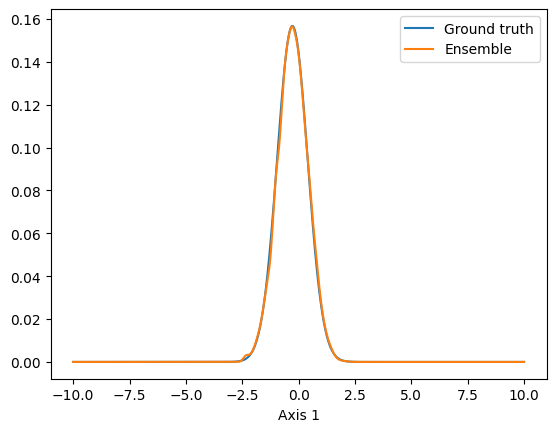

In [43]:
plot_marginal(w_i_final, model_probs, x_limits, ground_truth_generator, ground_truth_mean, ground_truth_cov, 
                  N_models, N_events, N_bumps, bumps_width, bumps_amplitude, axis=0)
plot_marginal(w_i_final, model_probs, x_limits, ground_truth_generator, ground_truth_mean, ground_truth_cov, 
                  N_models, N_events, N_bumps, bumps_width, bumps_amplitude, axis=1)

## fit model with extra NN and uncertainties

In [281]:
class GaussianKernelLayer(nn.Module):
    def __init__(self, centers_init, coefficients_init, sigma):
        """
        centers: torch.Tensor of shape (m, d)  -> Gaussian centers
        sigma: float or torch scalar           -> fixed std deviation
        """
        super().__init__()
        self.centers = nn.Parameter(centers_init.float(), requires_grad=True)  # trainable centers
        self.register_buffer('sigma', torch.tensor(sigma))        # non-trainable sigma
        self.coefficients = nn.Parameter(coefficients_init.float(), requires_grad=True) # trainable coefficients
        d = centers.shape[1]
        self.softmax = nn.Softmax()
        self.norm_const = (1.0 / ((2 * math.pi) ** (d / 2) * (self.sigma ** d)))

    def forward(self, x):
        """
        x: shape (N, d) -> batch of N points
        returns: shape (N, m) -> Gaussian kernel activations
        """
        # (N, 1, d) - (1, m, d) -> (N, m, d)
        diff = x.unsqueeze(1) - self.centers.unsqueeze(0)
        dist_sq = (diff ** 2).sum(dim=2)
        coeffs = self.softmax(self.coefficients)#/self.coefficients.sum()
        # Gaussian kernel with proper normalization
        return torch.einsum("a, ba -> b", coeffs, self.norm_const * torch.exp(-0.5 * dist_sq / (self.sigma ** 2)))


In [449]:
class TAU(nn.Module):
    """ 
    N= input_shape[0]
    m= number of elements in the ensemble
    
    """
    def __init__(self, input_shape, ensemble_probs, weights_init, weights_cov, weights_mean, 
                 gaussian_center, gaussian_coeffs,
                 lambda_regularizer=1e5, gaussian_sigma=0.1,
                 train_weights=True, train_net=True, 
                 model='TAU',name=None, **kwargs):
        super(TAU, self).__init__()
        self.ensemble_probs = ensemble_probs # [N, m]
        self.x_dim = input_shape[1]
        print("problem dimensionality:", self.x_dim)
        self.n_ensemble= ensemble_probs.shape[1]
        self.weights_cov= weights_cov # [m,m]
        self.weights_mean=weights_mean # [m,]
        self.lambda_regularizer = lambda_regularizer
        self.aux_model = torch.distributions.MultivariateNormal(weights_mean, covariance_matrix=weights_cov)
        self.weights = nn.Parameter(weights_init.reshape((self.n_ensemble)).type(torch.double), 
                               requires_grad=train_weights) # [M, 1]
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        self.train_net=train_net
        if self.train_net:
            self.coeffs = nn.Parameter(torch.tensor([1, 0.]).float(), requires_grad=True)
            self.network = GaussianKernelLayer(gaussian_center, gaussian_coeffs, gaussian_sigma)
            #self.network = nn.Sequential( nn.Linear(self.x_dim, 1000), nn.Sigmoid(), nn.Linear(1000, 1), nn.Sigmoid()) #flow
            
            
    def call(self, x):
        ensemble = torch.einsum("ij, jk -> ik", model_probs, torch.unsqueeze(self.weights, dim=1))
        #print(ensemble.shape)
        if self.train_net:
            net_out = self.network(x)
            return ensemble, net_out
        else:
            return ensemble

    def get_coeffs(self):
        return self.softmax(self.coeffs)

    def weights_constraint_term(self):
        return self.lambda_regularizer * (torch.sum(self.weights) - 1.0)**2 
    
    def net_constraint_term(self):
        squared_sum = 0.0
        for param in self.network.parameters():
            if param.requires_grad:
                squared_sum += torch.sum(param ** 2)
        return squared_sum
    
    def log_auxiliary_term(self):
        return self.aux_model.log_prob(self.weights) 

    def loglik(self, x):
        aux = self.log_auxiliary_term()
        if self.train_net:
            ensemble, net_out = self.call(x)
            coeffs = self.softmax(self.coeffs)

            #p = 0.5*(1+coeffs[0])*ensemble[:, 0] + 0.5*coeffs[1]*net_out
            p = coeffs[0]*ensemble[:, 0] + coeffs[1]*net_out
            return torch.log(p).sum() + aux.sum()
        else:
            p = self.call(x)
            return torch.log(p).sum() + aux.sum()
            
    def loss(self, x):
        aux = self.log_auxiliary_term()
        if self.train_net:
            ensemble, net_out = self.call(x)
            coeffs = self.softmax(self.coeffs)

            #p = 0.5*(1+coeffs[0])*ensemble[:, 0] + 0.5*coeffs[1]*net_out 
            p = coeffs[0]*ensemble[:, 0] + coeffs[1]*net_out 
            
            return -torch.log(p).sum() - aux.sum() + self.lambda_regularizer*self.weights_constraint_term()+self.lambda_regularizer*torch.sum(self.relu(-p)*torch.exp(-p))
        else:
            p = self.call(x)
            return -torch.log(p).sum() - aux.sum() + self.lambda_regularizer*self.weights_constraint_term()+self.lambda_regularizer*torch.sum(self.relu(-p)*torch.exp(-p))

        

## test denominator

In [462]:
epochs=100000
w_init = w

model = TAU((None, 2), ensemble_probs=model_probs, weights_init=w_init, weights_cov=w_cov, weights_mean=w, 
            gaussian_center=[], gaussian_coeffs=[], gaussian_sigma=None,
            lambda_regularizer=1e6, train_net=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_hist = []
epoch_hist = []
# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()          # Reset gradients
    loss = model.loss(torch.from_numpy(data).float())       # Forward pass
    loss.backward()                # Backpropagation
    optimizer.step()                # Update weights

    if (epoch+1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")
        loss_hist.append(loss.item())
        epoch_hist.append(epoch)

problem dimensionality: 2
Epoch [1000/100000] Loss: 2812.4946
Epoch [2000/100000] Loss: 2812.4946
Epoch [3000/100000] Loss: 2812.4946
Epoch [4000/100000] Loss: 2812.4946
Epoch [5000/100000] Loss: 2812.4946
Epoch [6000/100000] Loss: 2812.4946
Epoch [7000/100000] Loss: 2812.4946
Epoch [8000/100000] Loss: 2812.4946
Epoch [9000/100000] Loss: 2812.4946
Epoch [10000/100000] Loss: 2812.4946
Epoch [11000/100000] Loss: 2812.5324
Epoch [12000/100000] Loss: 2812.5026
Epoch [13000/100000] Loss: 21575.2019
Epoch [14000/100000] Loss: 4448.0904
Epoch [15000/100000] Loss: 2815.6741
Epoch [16000/100000] Loss: 2812.4982
Epoch [17000/100000] Loss: 2812.5412
Epoch [18000/100000] Loss: 2812.7215
Epoch [19000/100000] Loss: 2812.4988
Epoch [20000/100000] Loss: 2812.4946
Epoch [21000/100000] Loss: 2812.4946
Epoch [22000/100000] Loss: 2812.4946
Epoch [23000/100000] Loss: 2812.4946
Epoch [24000/100000] Loss: 2812.4946
Epoch [25000/100000] Loss: 2812.4946
Epoch [26000/100000] Loss: 2812.4946
Epoch [27000/100000]

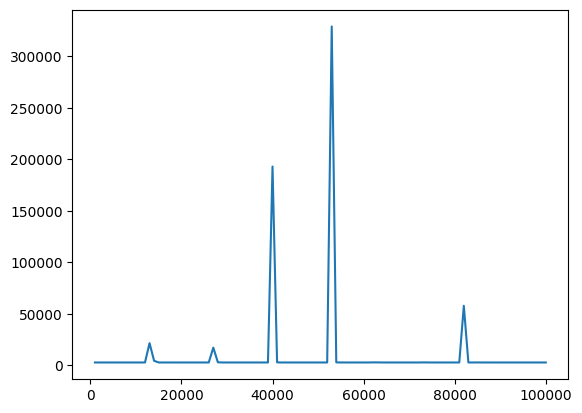

In [463]:
plt.plot(epoch_hist, loss_hist)

In [465]:
denominator = model.loglik(data).detach().numpy()
print('Denomiantor:', denominator)

Denomiantor: -2812.494500226456


torch.Size([10000, 5])


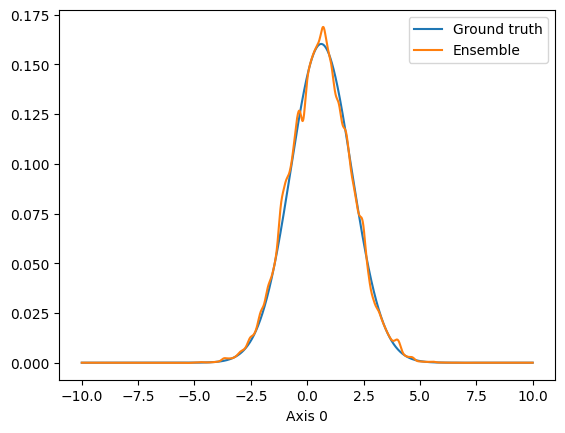

In [466]:
plot_marginal(model.weights.detach().numpy(), model_probs, x_limits, ground_truth_generator, ground_truth_mean, ground_truth_cov, 
                  N_models, N_events, N_bumps, bumps_width, bumps_amplitude, axis=0, nn=None)

## test numerator

In [467]:
epochs=50000
w_init = w

# additional degrees of freedom for the hypothesis at the numerator
n_kernels=20
centers = torch.from_numpy(data[:n_kernels])
coeffs = torch.ones((n_kernels,))/n_kernels

model = TAU((None, 2), ensemble_probs=model_probs, weights_init=w_init, weights_cov=w_cov, weights_mean=w, 
            gaussian_center=centers, gaussian_coeffs=coeffs, gaussian_sigma=0.3,
            lambda_regularizer=1e6, train_net=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_hist = []
epoch_hist = []
# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()          # Reset gradients
    loss = model.loss(torch.from_numpy(data).float()) # Forward pass
    loss.backward()                # Backpropagation
    optimizer.step()                # Update weights

    if (epoch+1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")
        loss_hist.append(loss.item())
        epoch_hist.append(epoch)

problem dimensionality: 2
Epoch [1000/50000] Loss: 2794.0215
Epoch [2000/50000] Loss: 2793.4647
Epoch [3000/50000] Loss: 2792.4368
Epoch [4000/50000] Loss: 2791.5709
Epoch [5000/50000] Loss: 2791.5703
Epoch [6000/50000] Loss: 2791.5701
Epoch [7000/50000] Loss: 2791.5700
Epoch [8000/50000] Loss: 472424.2928
Epoch [9000/50000] Loss: 3156.4753
Epoch [10000/50000] Loss: 3696.1989
Epoch [11000/50000] Loss: 2791.8429
Epoch [12000/50000] Loss: 2792.1435
Epoch [13000/50000] Loss: 2791.5696
Epoch [14000/50000] Loss: 2791.5695
Epoch [15000/50000] Loss: 2791.5646
Epoch [16000/50000] Loss: 2791.5645
Epoch [17000/50000] Loss: 2791.5587
Epoch [18000/50000] Loss: 2791.5200
Epoch [19000/50000] Loss: 2791.5200
Epoch [20000/50000] Loss: 2791.5201
Epoch [21000/50000] Loss: 2791.5200
Epoch [22000/50000] Loss: 2791.5201
Epoch [23000/50000] Loss: 72405.7677
Epoch [24000/50000] Loss: 13287.7678
Epoch [25000/50000] Loss: 82744.9340
Epoch [26000/50000] Loss: 124121.5803
Epoch [27000/50000] Loss: 2791.5323
Epoc

In [469]:
numerator = model.loglik(torch.from_numpy(data).float()).detach().numpy()
print('Numerator:', numerator)

Numerator: -2791.520085194943


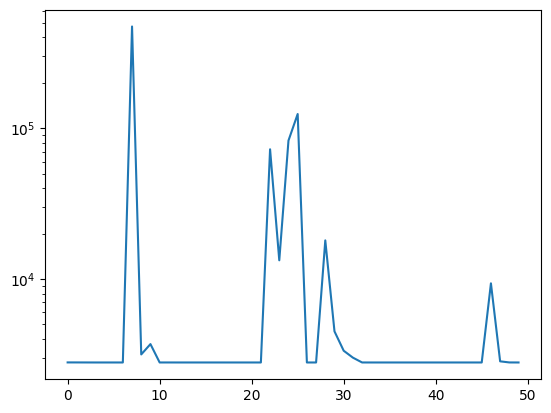

In [470]:
plt.plot(loss_hist[0:])
plt.yscale('log')

In [471]:
print('Mixture of ensemble and extra DOF. Coefficients:', model.get_coeffs().detach().numpy())

Mixture of ensemble and extra DOF. Coefficients: [0.6804977  0.31950232]


In [472]:
print('Ensemble weights after training: ', model.weights.detach().numpy())

Ensemble weights after training:  [-0.04329932  0.61159995 -0.01289999  0.46189919 -0.01729994]


torch.Size([10000, 5])


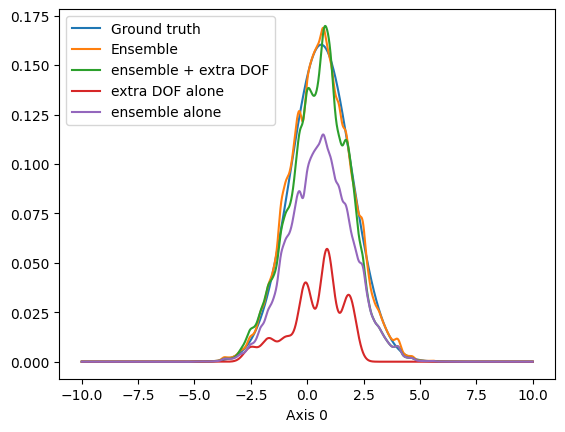

In [473]:
plot_marginal(model.weights.detach().numpy(), model_probs, x_limits, ground_truth_generator, ground_truth_mean, ground_truth_cov, 
                  N_models, N_events, N_bumps, bumps_width, bumps_amplitude, axis=0, nn=model.network, nn_coeff=model.get_coeffs().detach().numpy())

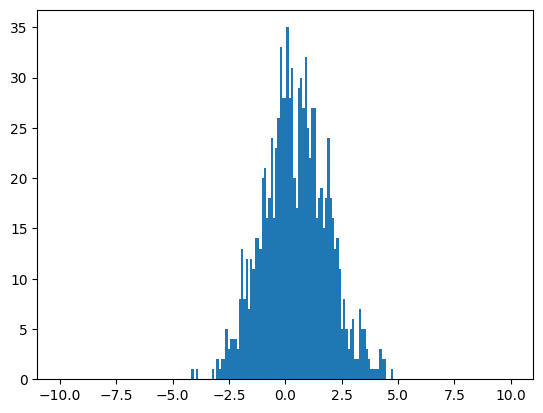

In [474]:
#training data distribution
plt.hist(data[:, 0], bins=np.linspace(-10, 10, 200))
plt.show()

In [101]:
for k in model.network.parameters():
    print(k)

Parameter containing:
tensor([[ 0.0606, -0.0943],
        [ 0.0502, -0.1174],
        [ 0.0516, -0.0785],
        [ 0.0802, -0.1567],
        [ 0.1013, -0.0018],
        [ 0.0380, -0.2167],
        [ 0.0697,  0.0664],
        [-0.0849, -0.0966],
        [ 0.0954, -0.1591],
        [ 0.0235, -0.1217]], requires_grad=True)
Parameter containing:
tensor([2.8054, 3.1288, 3.1814, 2.2277, 2.7400, 2.4131, 3.1871, 3.2087, 2.4143,
        2.5920], requires_grad=True)
Parameter containing:
tensor([[1.3899, 1.5058, 1.9146, 1.9398, 1.1216, 1.6447, 2.1154, 1.4847, 1.6570,
         1.8841],
        [1.3370, 1.3707, 1.5444, 1.9820, 1.6778, 1.4790, 1.8880, 1.2429, 1.9693,
         2.0566]], requires_grad=True)
Parameter containing:
tensor([1.3151, 1.3835], requires_grad=True)


In [475]:
test= numerator -denominator
print('test: ', test)

test:  20.974415031512763
